In [135]:
from graspologic.align import OrthogonalProcrustes
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.plot import pairplot
from graspologic.simulations import sample_edges
from pkg.inference import difference
from pkg.plot import heatmap

from hyppo.independence import Dcorr

In [74]:
n = 25

B1 = np.array([[0.5, 0.2], [0.2, 0.5]])
P1 = np.repeat(np.repeat(B1, n, 0), n, 1)
B2 = np.array([[0.72, 0.192], [0.192, 0.32]])
P2 = np.repeat(np.repeat(B1, n, axis=0), n, axis=1)
B3 = np.array([[0.7, 0.2], [0.2, 0.7]])
P3 = np.repeat(np.repeat(B3, n, axis=0), n, axis=1)

In [80]:
def compute_diff_mats(X, Y, d=2):
    X_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(X)
    Y_hat = AdjacencySpectralEmbed(n_components=d, check_lcc=False).fit_transform(Y)

    exact = difference(X_hat, Y_hat, "exact")
    exact_norm = np.linalg.norm(exact)
    exact = exact @ exact.T

    global_ = difference(X_hat, Y_hat, "global")
    global_norm = np.linalg.norm(global_)
    global_ = global_ @ global_.T

    vertex = difference(X_hat, Y_hat, "vertex")
    vertex_norm = np.linalg.norm(vertex)
    vertex = vertex @ vertex.T

    idx = np.diag_indices_from(exact)
    exact[idx] = 0
    global_[idx] = 0
    vertex[idx] = 0

    return exact_norm, global_norm, vertex_norm

In [141]:
n = 25
node_labels = ["Left"] * n + ["Right"] * n

u = np.array(
    [
        [1 / 4, 3 / 4],
        [3 / 4, 1 / 4],
    ]
)
X = np.tile(u, 25).reshape(-1, 2)

degree_correction = np.diag(np.random.uniform(0.9, 1, size=50))
P1 = X @ X.T
P2 = degree_correction @ X @ X.T @ degree_correction

In [142]:
A = sample_edges(P1)
B = sample_edges(P2)

compute_diff_mats(A, B)

(2.455426219419582, 1.2208861244567932, 2.842111411482238)

In [143]:
X1 = AdjacencySpectralEmbed(2).fit_transform(A)
X2 = AdjacencySpectralEmbed(2).fit_transform(B)

/home/j1c/.cache/pypoetry/virtualenvs/connectomic-heritability-4Wi0NQQ2-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/j1c/.cache/pypoetry/virtualenvs/connectomic-heritability-4Wi0NQQ2-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/j1c/.cache/pypoetry/virtualenvs/connectomic-heritability-4Wi0NQQ2-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/home/j1c/.cache/pypoetry/virtualenvs/connectomic-heritability-4Wi0NQQ2-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


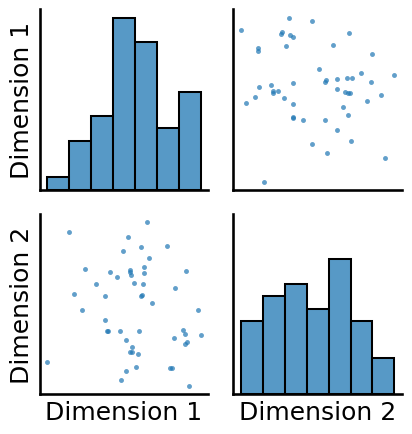

In [138]:
pairplot(
    X2,
)

In [139]:
normX1 = np.linalg.norm(X1, axis=1)
normX2 = np.linalg.norm(X2, axis=1)

x1dx = normX1 <= 1e-10
normX1[x1dx] = 1
x2dx = normX2 <= 1e-10
normX2[x2dx] = 1

X1 = X1 / normX1[:, None]
X2 = X2 / normX2[:, None]

denom = normX1[~x1dx].min() + normX2[~x2dx].min()
X1 /= denom
X2 /= denom

X1 = OrthogonalProcrustes().fit_transform(X1, X2)
print(np.linalg.norm(X1 - X2))

2.8148529819544663


In [164]:
X1 = AdjacencySpectralEmbed(2).fit_transform(A)
X2 = AdjacencySpectralEmbed(2).fit_transform(B)

In [178]:
difference_norm(X1, X2, "exact")

1.212985461096899

In [170]:
difference_norm(X1, X2, "vertex")

0.16580492600802774

In [174]:
compute_constant(X1)

1.2499682957035008

In [171]:
import numpy as np
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes


def difference(
    X1: np.ndarray,
    X2: np.ndarray,
    test_case,
) -> float:
    if test_case == "exact":
        CX = compute_constant(X1)
        CY = compute_constant(X2)

        denom = CX + CY

        # X1 /= denom
        # X2 /= denom
    elif test_case == "global":
        CX = compute_constant(X1)
        CY = compute_constant(X2)

        normX1 = np.linalg.norm(X1, ord="fro")
        normX2 = np.linalg.norm(X2, ord="fro")
        X1 = X1 / normX1
        X2 = X2 / normX2

        denom = 2 * (CX / normX1 + CY / normX2)

        # X1 /= denom
        # X2 /= denom

    elif test_case == "vertex":
        normX1 = np.sum(X1**2, axis=1)
        normX2 = np.sum(X2**2, axis=1)
        normX1[normX1 <= 1e-15] = 1
        normX2[normX2 <= 1e-15] = 1
        X1 = X1 / np.sqrt(normX1[:, None])
        X2 = X2 / np.sqrt(normX2[:, None])

        denom = 2 * (1 / np.sqrt(normX1).min() + 1 / np.sqrt(normX2).min())
        # X1 /= denom
        # X2 /= denom
    else:
        raise ValueError()

    aligner = OrthogonalProcrustes()
    X1 = aligner.fit_transform(X1, X2)
    X1 /= denom
    X2 /= denom
    return X1 - X2


def compute_constant(X):
    P = X @ X.T
    D = np.sum(P - P**2, axis=1)
    D[D < 0] = 0
    D = D.reshape(-1, 1)

    S, U = np.linalg.eig(X.T @ X)
    C = U @ np.diag(1 / S**2) @ U.T
    CX = np.sum(np.diag(C @ (X * np.sqrt(D)).T @ (X * np.sqrt(D))))

    return np.sqrt(CX)


def difference_norm(
    X1: np.ndarray,
    X2: np.ndarray,
    test_case,
) -> float:
    X = difference(X1, X2, test_case)

    return np.linalg.norm(X)

In [193]:
w = np.array(
    [
        [3 / 6, 2 / 6],
        [2 / 6, 1 / 6],
    ]
)

In [194]:
w @ w.T

array([[0.36111111, 0.22222222],
       [0.22222222, 0.13888889]])